# Clustering Textual Doc2Vec

Clustering (agrupamento) é uma das tarefas mais icônicas dentro da área de aprendizado não-supervisionado. Nela, um algoritmo aprende a detectar "grupos naturais" dentro do nosso conjunto de dados.

Neste material, nos dedicamos à criação de modelos de clustering textual. O agrupamento de textos semelhantes pode ser uma tarefa muito útil para muitas aplicações. Entretanto, pode se tornar muito difícil, dada a natureza ruidosa e complexa da linguagem humana natural. Além disso, algoritmos não-supervisionados são complexos de treinar, já que não possuímos um "alvo" ao qual tentamos nos aproximar.


## Dados utilizados

Vamos usar os dados do dataset 20newsgroups disponível através do Sklearn.

Os dados utilizados já possuem rótulos definidos, o que nos ajudará a avaliar a qualidade do agrupamento feito.
 
*Obs. A tarefa de clusterização faz parte dos algoritmos não supervisionados, utilizamos os rótulos do dataset apenas com caráter avaliativo, em nenhum momento eles são usados para treinar nenhum modelo.*

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(subset='all', 
                          random_state=214, 
                          remove=('headers', 'footers', 'quotes'))

text_original, text_labels = data['data'], data['target']
label_names = data['target_names']

In [ ]:
text_original[0]

'I like option C of the new space station design.. \nIt needs some work, but it is simple and elegant..\n\nIts about time someone got into simple construction versus overly complex...\n\nBasically just strap some rockets and a nose cone on the habitat and go for\nit..\n\nMight be an idea for a Moon/Mars base to.. '

Para prosseguir, iremos tokenizar os textos com uso do NLTK, além de realizar um procedimento de stemming e remoção de stopwords.


In [ ]:
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

text_corpus = [word_tokenize(text) for text in text_original]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stemmer = SnowballStemmer(language="english")
en_stopwords = stopwords.words('english')
text_corpus = [ [ stemmer.stem(word) for word in sentence if word.lower() not in en_stopwords ] for sentence in text_corpus ]

In [ ]:
print(text_corpus[0])
print(text_corpus[1])
print(text_corpus[2])

['like', 'option', 'c', 'new', 'space', 'station', 'design..', 'need', 'work', ',', 'simpl', 'elegant..', 'time', 'someon', 'got', 'simpl', 'construct', 'versus', 'over', 'complex', '...', 'basic', 'strap', 'rocket', 'nose', 'cone', 'habitat', 'go', 'it..', 'might', 'idea', 'moon/mar', 'base', 'to..']
['mcsdc1jpb', '@', 'dct.ac.uk', '(', 'john', 'bell', ')', 'babbl', 'scotland', ',', 'one', 'england', 'last', 'remain', 'coloni', ':', 'peopl', 'dumb', 'enough', 'believ', 'klinton', 'moder', 'deserv', 'get', '.', "'s", 'real', 'laugh', 'hear', 'tri', 'justifi', 'massacr', 'bullsh*t', 'concern', 'tax', 'money', 'spent', '.', '(', 'wast', 'money', 'keep', 'texan', 'aliv', '?', 'hell', '.', 'let', 'spend', 'import', 'haitian', 'aid', 'treat', 'taxpay', 'expens', '.', '%', '^p', ')', '?', 'fed', 'kill', '90+', 'civilian', '``', 'ran', 'patienc', "''", ',', 'use', 'phrase', '.', 'fed', "n't", 'attack', ',', "'d", 'home', 'eat', 'dinner', 'famili', 'tonight', '.', 'bad', ',', 'start', '.', 'ma

## Doc2Vec

Para implementar a vetorização de documentos, utilizaremos o Gensim com sua implementação do Doc2Vec.

In [ ]:
!pip show gensim

Name: gensim
Version: 3.6.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, scipy, numpy, smart-open
Required-by: 


Um pré requisito do modelo Doc2Vec do Gensim é que os textos sejam transformados em TaggedDocuments.

In [ ]:
import gensim
from gensim.models import Doc2Vec

# To use gensim's doc2vec model, all texts need to be TaggedDocument objects 

tagged_text = [ gensim.models.doc2vec.TaggedDocument(text, [i]) for i,text in enumerate(text_corpus) ]

Agora, vamos instanciar e treinar o modelo Doc2Vec.

In [ ]:
%%time
doc2vec_model = Doc2Vec(tagged_text,                    
                        vector_size=250,
                        epochs=120,
                        min_count=5,
                        workers=4, # Computacional Parameters
                        seed=214)


CPU times: user 28min 28s, sys: 1min 7s, total: 29min 35s
Wall time: 17min 7s


Para acessar os vetores por documentos, utilizamos a tag criada para cada TaggedDocument.

In [ ]:
doc2vec_model.docvecs[0].shape

(250,)

In [ ]:
text_vectors = doc2vec_model.docvecs.vectors_docs

## Clustering com KMeans

A primeira abordagem proposta é aplicar o algoritmo de clusterização diretamente nos vetores criados.

Utilizamos o algoritmo KMeans disponível no Sklearn. 

Já sabemos, a priori, que os textos se dividem em 20 classes. Porém, com o intuito de simular um algoritmo criado às cegas, iremos instanciar o modelo do KMeans com 10 clusters.


In [ ]:
%%time
from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

import numpy as np

km_clt = KMeans(10, n_init=200, random_state=214)
vector_labels = km_clt.fit_predict(text_vectors)

CPU times: user 4min 5s, sys: 1min, total: 5min 6s
Wall time: 3min 56s


Para avaliar a natureza dos clusters criados, iremos contar quantos textos de cada classe se encontram em cada um deles.

O ideal é que um mesmo cluster contenha somente textos de classes semelhantes.

Homogeneity Score -  0.29272160207768916
Completeness Score -  0.4513588478144568


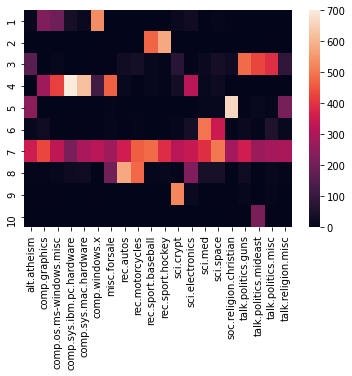

In [ ]:
import pandas as pd
from seaborn import heatmap
import matplotlib.pyplot as plt

df = pd.DataFrame()
for i in range( len(np.unique(km_clt.labels_)) ):
  unique, counts = np.unique(text_labels[np.where(vector_labels==i)[0]], 
                             return_counts=True)
  
  df_aux = pd.DataFrame( dict(zip(unique, counts)), index=[i+1] )
  df = pd.concat([df, df_aux], axis=0)

df=df.fillna(0)
df=df.rename(columns=dict(enumerate(label_names)))
df=df.astype('int32')

heatmap(df)
print( "Homogeneity Score - ", homogeneity_score(text_labels,vector_labels) )
print( "Completeness Score - ", completeness_score(text_labels,vector_labels) )

Como podemos ver, o algoritmo foi capaz de capturar razoávelmente bem os assuntos textuais. Os grupos criados consguem agrupar temas similares com "alta consistência", isto é, contendo majoritariamente textos da mesma temática.

O cluster 9, por exemplo, agrupa todos os temas relacionados à hardware e eletrônica. Por mais que eles estejam originalmente separados no nosso dataset, esses temas possuem forte correlação entre si, fato confirmado pelo KMeans.

O mesmo se repete para o cluster 8, que contém temas voltados à religião, etc.

Isto demonstra, também, que nossos vetores Doc2Vec de fato conseguem representar a semântica textual, fazendo com que textos semelhantes fiquem mais próximos, ao ponto de formar núcleos ao longo do espaço vetorial.

Em contra partida, boa parte dos textos ainda se encontra "sem classe", agrupados em um único grande cluster de tema "indefinido".